https://towardsdatascience.com/an-overview-of-time-series-forecasting-models-a2fa7a358fcb

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from livelossplot.keras import PlotLossesCallback

<Figure size 1080x288 with 0 Axes>

In [2]:
df = pd.read_csv("elecequip.csv")
df.head(10)

,Index,x
0,1996.000000,79.35
1,1996.083333,75.78
2,1996.166667,86.32
3,1996.250000,72.60
4,1996.333333,74.86
5,1996.416667,83.81
6,1996.500000,79.80
7,1996.583333,62.41
8,1996.666667,85.41
9,1996.750000,83.11


In [3]:
# Transform Index to datetime

def IdxToYear(row):
    return int(row)

def IdxToMonth(row):
    global idx
    idx = idx + 1
    idx = 1 if idx == 13 else idx
    return idx

idx=0
df['Year']  = df.Index.apply(lambda x : IdxToYear(x))
df['Month'] = df.Index.apply(lambda x : IdxToMonth(x))

In [4]:
df.head()

,Index,x,Year,Month
0,1996.000000,79.35,1996,1
1,1996.083333,75.78,1996,2
2,1996.166667,86.32,1996,3
3,1996.250000,72.60,1996,4
4,1996.333333,74.86,1996,5


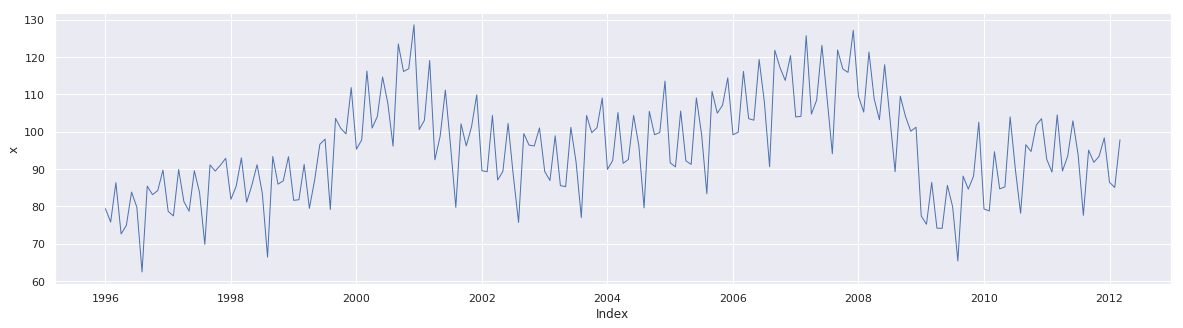

In [5]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Index', y='x', data=df, linewidth=1)

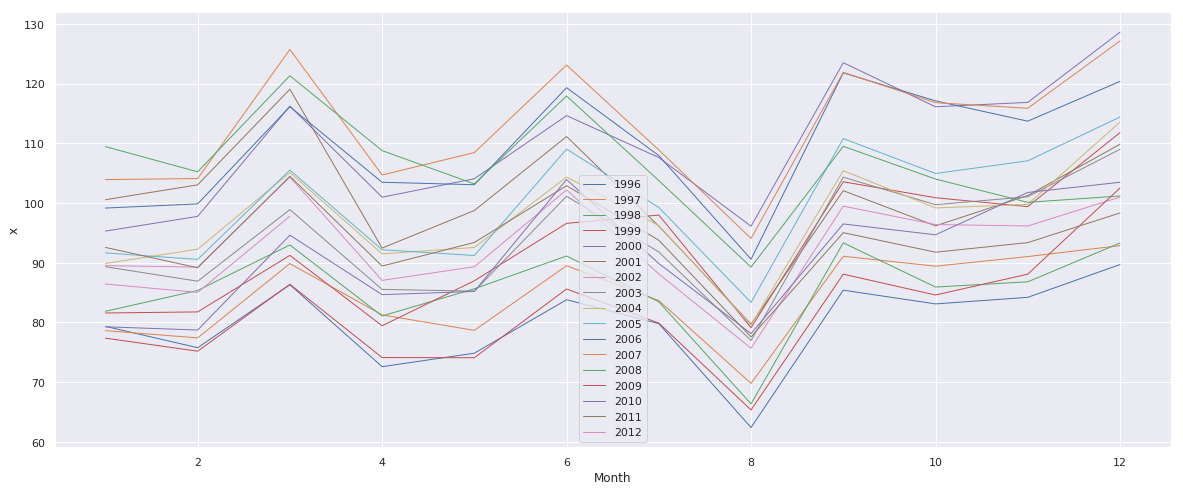

In [6]:
plt.figure(figsize=(20,8))

for i in range(1996, 2013):
     sns.lineplot(x='Month', y='x', data=df[df['Year'] == i], linewidth=1, label=i)


## Naive model


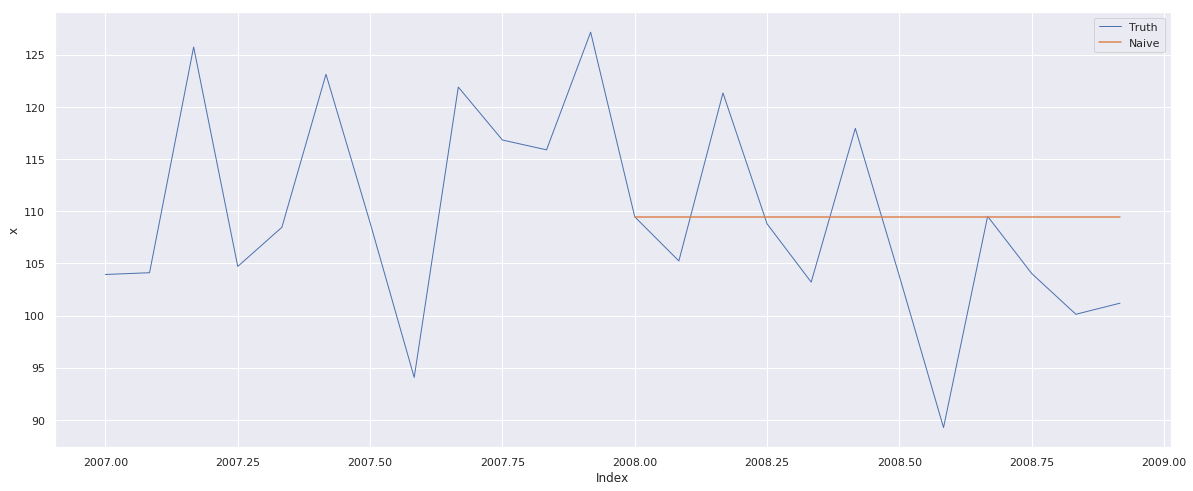

In [7]:
truth = df[(df['Year'] >= 2007) & (df['Year'] < 2009)]
naive = truth[truth['Year'] == 2008]
naive['x'] = df[(df['Year'] == 2008) & (df['Month'] == 1)]['x'].values[0]

plt.figure(figsize=(20,8))
sns.lineplot(x='Index', y='x', data=truth, linewidth=1, label='Truth')
sns.lineplot(x='Index', y='x', data=naive, linewidth=1.5, label='Naive')


## Seasonal Naive

In [8]:
result = seasonal_decompose(df.x.values, model='additive',freq=12, two_sided = False,)
#2007 seasonality
result.seasonal[11*12:12*12] 

array([ -5.75982017,  -6.10614829,   8.09171629,  -6.15164482,
        -4.70395038,   8.03552185,  -1.66764482, -16.85858927,
         7.38318851,   2.75771629,   3.67954962,  11.30010518])

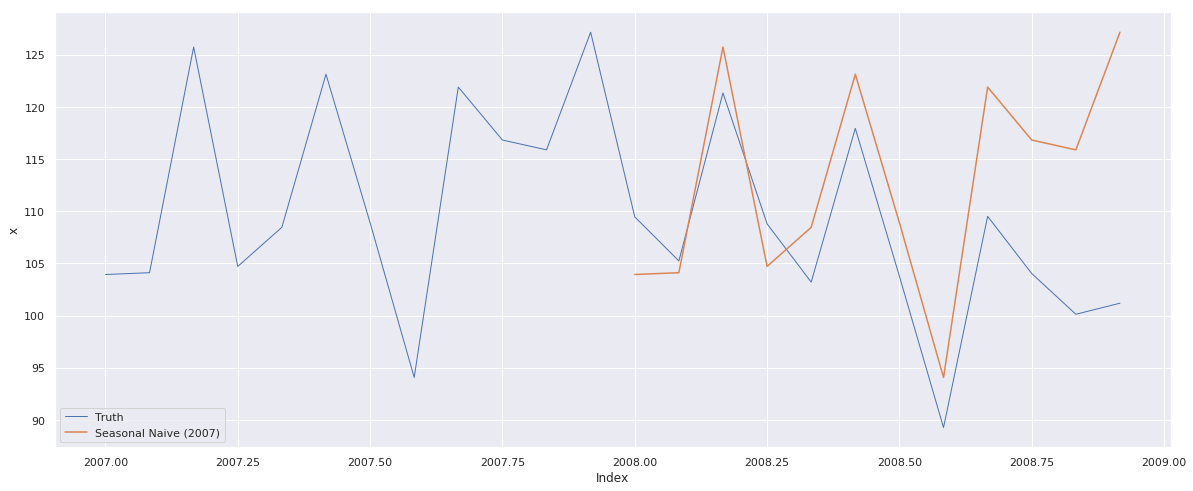

In [9]:
snaive = df[df['Year'] == 2008]
snaive['x'] = df[df['Year'] == 2007].x.values

plt.figure(figsize=(20,8))
sns.lineplot(x='Index', y='x', data=truth, linewidth=1, label='Truth')
sns.lineplot(x='Index', y='x', data=snaive, linewidth=1.5, label='Seasonal Naive (2007)')


## Seasonality decomposition + model

### compute seasonality

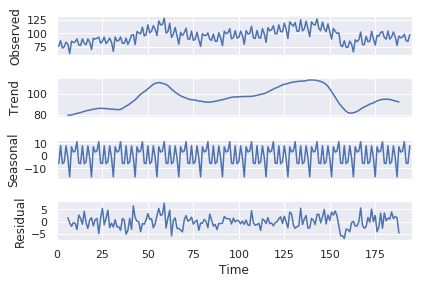

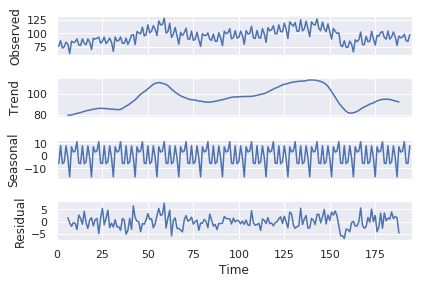

In [10]:
result = seasonal_decompose(df.x.values, model='additive',freq=12)
result.plot()

In [11]:
deseasonalised = df.x.values - result.seasonal 

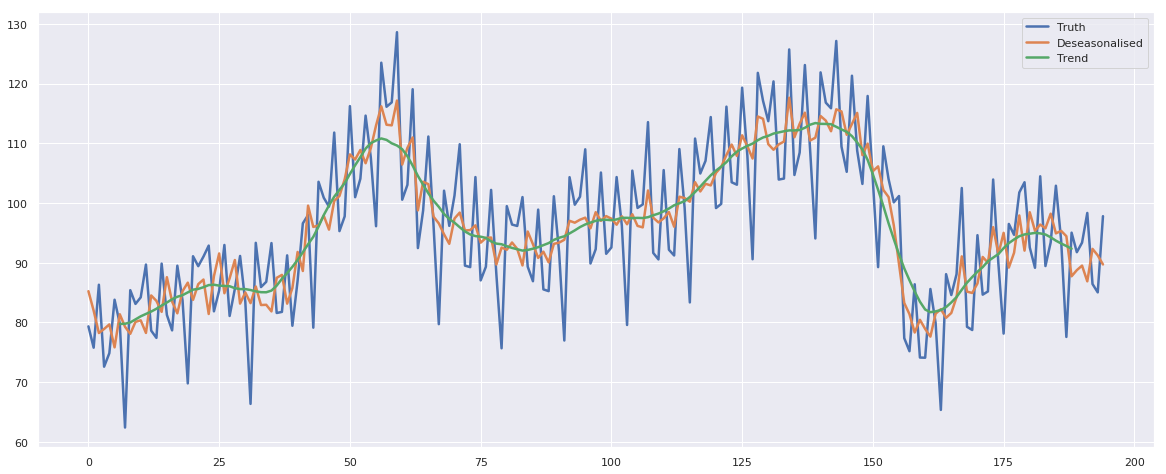

In [12]:
plt.figure(figsize=(20,8))
plt.plot(df.x.values, label='Truth', linewidth=2.5)
plt.plot(deseasonalised, label='Deseasonalised', linewidth=2.5)
plt.plot(result.trend, label='Trend', linewidth=2.5)
plt.legend()

### evaluate stationarity, AIC, BIC, ...

In [13]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df.x.values)

#of course it's stationary -> p-value == 0.03

Results of Dickey-Fuller Test:
Test Statistic                  -2.981271
p-value                          0.036681
#Lags Used                      15.000000
Number of Observations Used    179.000000
Critical Value (1%)             -3.467420
Critical Value (5%)             -2.877826
Critical Value (10%)            -2.575452
dtype: float64


In [14]:
def create_dataset(arr, win = 12):
    train = list()
    test  = list()
    for i in range(win, arr.shape[0]):
        train.append(arr[i-win:i])
        test.append(arr[i])
    return np.array(train), np.array(test)

In [27]:
train_12, test_12  = create_dataset(deseasonalised)

train_6, test_6  = create_dataset(deseasonalised, 6)

train_3, test_3  = create_dataset(deseasonalised, 3)

def train_test_split(train, test, perc = 0.7):
    idx = int(train.shape[0] * perc)
    return train[:idx], train[idx:], test[:idx], test[idx:]

x_train_12, x_test_12, y_train_12, y_test_12 = train_test_split(train_12, test_12)
x_train_6, x_test_6, y_train_6, y_test_6 = train_test_split(train_6, test_6)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(train_3, test_3)

In [16]:
x_train_12.shape
x_test_12.shape


(55, 12)

### Predict with OLS

In [28]:
regr_12 = OLS(y_train_12, x_train_12).fit()
print("AIC 12",regr_12.aic)
ols_12_pred = regr_12.predict(x_test_12)
print("OLS window 12 MSE",mean_squared_error(y_test_12, ols_12_pred))

regr_6 = OLS(y_train_6, x_train_6).fit()
print("AIC 6",regr_6.aic)
ols_6_pred = regr_6.predict(x_test_6)
print("OLS window 6 MSE",mean_squared_error(y_test_6, ols_6_pred))

regr_3 = OLS(y_train_3, x_train_3).fit()
print("AIC 3",regr_3.aic)
ols_3_pred = regr_3.predict(x_test_3)
print("OLS window 3 MSE",mean_squared_error(y_test_3, ols_3_pred))

AIC 12 644.2082400453339
OLS window 12 MSE 13.908537858202939
AIC 6 662.3272937746004
OLS window 6 MSE 14.052312585162813
AIC 3 677.9165197172667
OLS window 3 MSE 16.29973948282546


### Predict with Linear Regressor

In [29]:
# scaling
# scaler = StandardScaler()
# scaler = scaler.fit(y.reshape(-1,1))
# y_scaled = scaler.transform(y.reshape(-1,1))

# fitting model
model_12 = LinearRegression()
model_12 = model_12.fit(x_train_12, y_train_12)

model_6 = LinearRegression()
model_6 = model_6.fit(x_train_6, y_train_6)

model_3 = LinearRegression()
model_3 = model_3.fit(x_train_3, y_train_3)
 
pred_12 = model_12.predict(x_test_12)
pred_6 = model_6.predict(x_test_6)
pred_3 = model_3.predict(x_test_3)
print("Linear Regressor window 12 MSE",mean_squared_error(y_test_12, pred_12))
print("Linear Regressor window 6 MSE",mean_squared_error(y_test_6, pred_6))
print("Linear Regressor window 3 MSE",mean_squared_error(y_test_3, pred_3))

Linear Regressor window 12 MSE 13.211043958838415
Linear Regressor window 6 MSE 13.27924792023438
Linear Regressor window 3 MSE 15.875352019620568


### Plot results

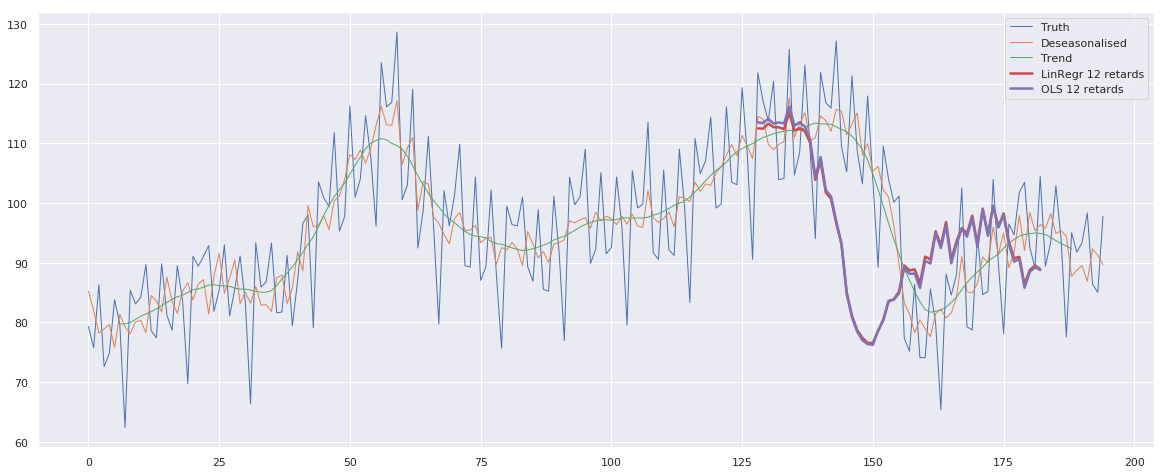

In [32]:
plt.figure(figsize=(20,8))
plt.plot(df.x.values, label='Truth', linewidth=1)
plt.plot(deseasonalised, label='Deseasonalised', linewidth=1)
plt.plot(result.trend, label='Trend', linewidth=1)
idx = int(train_12.shape[0] * 0.7)
plt.plot(np.concatenate((np.tile(np.nan, (idx)), pred_12)), label='LinRegr 12 retards', linewidth=2.5)
plt.plot(np.concatenate((np.tile(np.nan, (idx)), ols_12_pred)), label='OLS 12 retards', linewidth=2.5)
plt.legend()

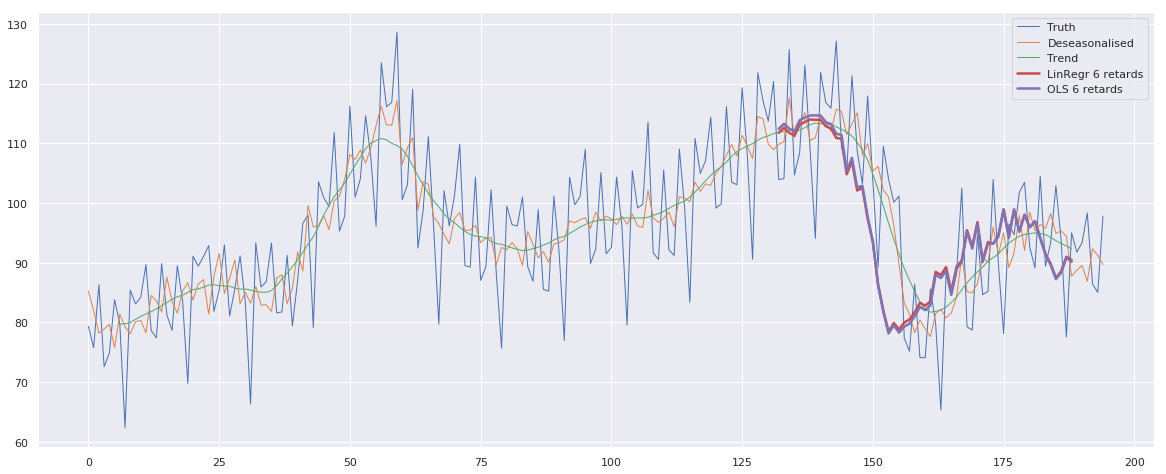

In [33]:
plt.figure(figsize=(20,8))
plt.plot(df.x.values, label='Truth', linewidth=1)
plt.plot(deseasonalised, label='Deseasonalised', linewidth=1)
plt.plot(result.trend, label='Trend', linewidth=1)
idx = int(train_6.shape[0] * 0.7)
plt.plot(np.concatenate((np.tile(np.nan, (idx)), pred_6)), label='LinRegr 6 retards', linewidth=2.5)
plt.plot(np.concatenate((np.tile(np.nan, (idx)), ols_6_pred)), label='OLS 6 retards', linewidth=2.5)
plt.legend()

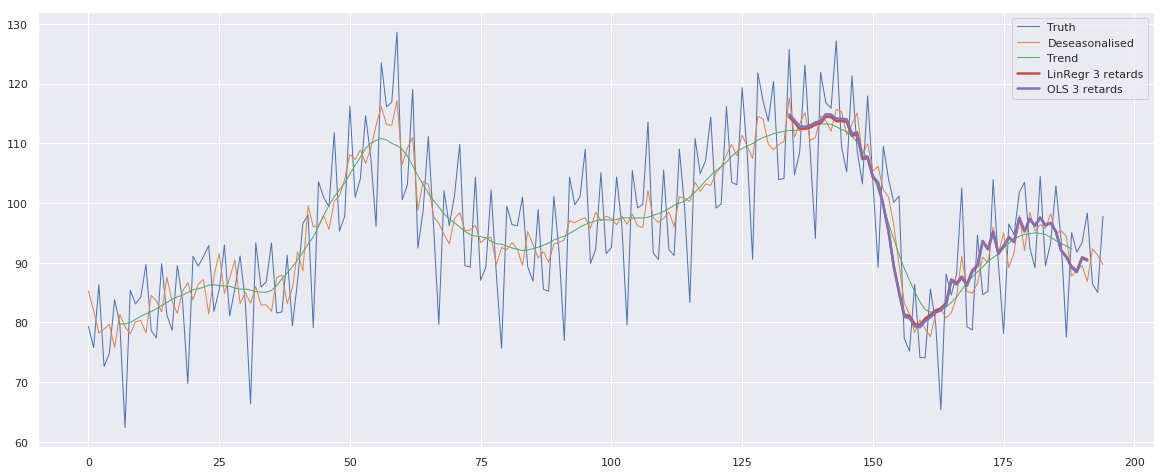

In [34]:
plt.figure(figsize=(20,8))
plt.plot(df.x.values, label='Truth', linewidth=1)
plt.plot(deseasonalised, label='Deseasonalised', linewidth=1)
plt.plot(result.trend, label='Trend', linewidth=1)
idx = int(train_3.shape[0] * 0.7)
plt.plot(np.concatenate((np.tile(np.nan, (idx)), pred_3)), label='LinRegr 3 retards', linewidth=2.5)
plt.plot(np.concatenate((np.tile(np.nan, (idx)), ols_3_pred)), label='OLS 3 retards', linewidth=2.5)
plt.legend()